In [1]:
import sys; sys.path.append('..')

import numpy as np
import torch
from utils.wandb_loader import get_sweep_results

from shape_transformers.model.shape_transformer import ShapeTransformer
from train import get_data_loaders

In [2]:
df = get_sweep_results(sweep_id='9mk7pvt0', lazy=False)

In [3]:
df

,_step,Val/L2,epoch,val_fold,run_id,lr,device,momentum,data_path,load_ckpt,...,subsample_seed,val_batch_size,k_fold_val_fold,lr_warmup_steps,max_num_3d_logs,num_accum_steps,higher_is_better,k_fold_num_folds,disentangle_style,n_verts_subsample
0,1867,1.286962,21,0,tsd0f0nv,0.005,cuda,0.99,/apollo/datasets/NPHM,None,...,15,16,0,1000,0,1,False,5,False,5000
1,2207,1.299247,25,0,tsd0f0nv,0.005,cuda,0.99,/apollo/datasets/NPHM,None,...,15,16,0,1000,0,1,False,5,False,5000
2,3312,0.911614,38,0,tsd0f0nv,0.005,cuda,0.99,/apollo/datasets/NPHM,None,...,15,16,0,1000,0,1,False,5,False,5000
3,3652,0.927887,42,0,tsd0f0nv,0.005,cuda,0.99,/apollo/datasets/NPHM,None,...,15,16,0,1000,0,1,False,5,False,5000
4,4927,0.955288,57,0,tsd0f0nv,0.005,cuda,0.99,/apollo/datasets/NPHM,None,...,15,16,0,1000,0,1,False,5,False,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,386322,0.607774,4544,0,tsd0f0nv,0.005,cuda,0.99,/apollo/datasets/NPHM,None,...,15,16,0,1000,0,1,False,5,False,5000
459,386662,0.605417,4548,0,tsd0f0nv,0.005,cuda,0.99,/apollo/datasets/NPHM,None,...,15,16,0,1000,0,1,False,5,False,5000
460,387257,0.599884,4555,0,tsd0f0nv,0.005,cuda,0.99,/apollo/datasets/NPHM,None,...,15,16,0,1000,0,1,False,5,False,5000
461,388532,0.600261,4570,0,tsd0f0nv,0.005,cuda,0.99,/apollo/datasets/NPHM,None,...,15,16,0,1000,0,1,False,5,False,5000


In [4]:
device = 'cuda'
run_id = 'tsd0f0nv'

row = df[df['run_id'] == run_id].iloc[0]
token_size = row['token_size']
disentangle_style = row['disentangle_style']

model = ShapeTransformer(token_size, disentangle_style)
ckpt = torch.load(f'../ckpts/{run_id}_best.pth')
model.load_state_dict(ckpt)
model.eval()
model = model.to(device)

In [5]:
dl_train, dl_val, dl_test = get_data_loaders(
    row.data_path, row.scan_type, not row.keep_bad_scans, row.n_verts_subsample,
    row.subsample_seed, row.k_fold_num_folds, row.k_fold_val_fold, row.k_fold_seed,
    batch_size=10, val_batch_size=1, num_workers=8
)

ds = dl_val.dataset
ds.transform = ds.transform.transforms[0]

In [6]:
def get_pred_gt_shape(sample_idx):
    true_rel_verts, positions, triangles, labels = ds[sample_idx]

    with torch.no_grad():
        pred_rel_verts = model(positions[None, ...].to(device),
                               true_rel_verts[None, ...].to(device)).cpu().squeeze()

    shape_norm = ds.transform
    true_verts = shape_norm.inverse(true_rel_verts)
    pred_verts = shape_norm.inverse(pred_rel_verts)

    return true_verts, pred_verts, triangles


def get_interpolated_shape(idx1, idx2, alpha):
    true_rel_verts_1, positions, triangles, _ = ds[idx1]
    true_rel_verts_2, _, _, _ = ds[idx2]

    with torch.no_grad():
        shape_code_1 = model.encoder(
            positions[None, ...].to(device),
            true_rel_verts_1[None, ...].to(device)
        )
        shape_code_2 = model.encoder(
            positions[None, ...].to(device),
            true_rel_verts_2[None, ...].to(device)
        )
        shape_code = (
            (1 - alpha) * shape_code_1
            + alpha * shape_code_2
        )
        pred_rel_verts = model.decoder(
            positions[None, ...].to(device),
            shape_code
        ).cpu().squeeze()

    shape_norm = ds.transform
    true_verts_1 = shape_norm.inverse(true_rel_verts_1)
    true_verts_2 = shape_norm.inverse(true_rel_verts_2)
    pred_verts = shape_norm.inverse(pred_rel_verts)

    return true_verts_1, true_verts_2, pred_verts, triangles

In [7]:
from ipygany import Scene, PolyMesh
import numpy as np


def get_scene_from_mesh(vertices, triangles):
    return Scene([
        PolyMesh(
            vertices=np.asarray(vertices),
            triangle_indices=np.asarray(triangles)
        )
    ])

In [8]:
from ipywidgets import HBox, VBox, interact, BoundedIntText, FloatSlider

In [9]:
@interact(
    sample_idx=BoundedIntText(
        value=0,
        min=0,
        max=len(ds) - 1,
        description='Sample idx:',
    )
)
def show_pred_gt_shape(sample_idx):
    true_verts, pred_verts, triangles = get_pred_gt_shape(sample_idx)
    true_scene = get_scene_from_mesh(true_verts.numpy(), triangles.numpy())
    pred_scene = get_scene_from_mesh(pred_verts.numpy(), triangles.numpy())
    return VBox([true_scene, pred_scene])

interactive(children=(BoundedIntText(value=0, description='Sample idx:', max=1080), Output()), _dom_classes=('…

In [11]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

In [12]:
from scipy.spatial.transform import Rotation


def get_camera_pose(x, y, z, pitch, yaw, roll):
    euler_angles = [pitch, yaw, roll]
    rotation = Rotation.from_euler('xyz', np.radians(euler_angles)).as_matrix()
    rotation
    translation = np.array([x, y, z])
    pose_world = np.vstack([
        np.hstack([rotation, translation[:, None]]),
        np.array([0, 0, 0, 1])
    ])
    pose_cam = np.linalg.inv(pose_world)
    return pose_cam

In [13]:
from trimesh import Trimesh
import pyrender
import matplotlib.pyplot as plt
import time


def render_mesh(vertices, triangles):
    tm = Trimesh(vertices, triangles)
    mesh = pyrender.Mesh.from_trimesh(tm)

    # compose scene
    scene = pyrender.Scene(ambient_light=[.1, .1, .3], bg_color=[255, 255, 255])
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 6.0)
    light = pyrender.DirectionalLight(color=[1,1,1], intensity=2e3)

    scene.add(mesh, pose=np.eye(4))
    scene.add(light, pose=np.eye(4))

    cam_pose = get_camera_pose(
        x=0, y=.1, z=-2.5,
        pitch=0, yaw=0, roll=0
    )
    scene.add(camera, pose=cam_pose)

    # render scene
    r = pyrender.OffscreenRenderer(512, 512)

    try:
        color, depth = r.render(scene)
        return color
    except:
        print('Render failed')

897


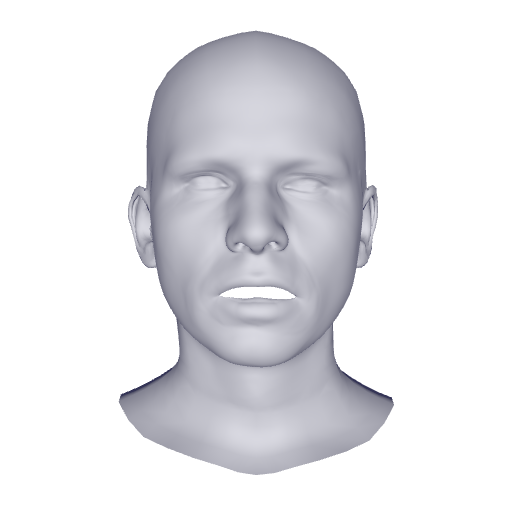

In [21]:
from random import randint


sample_idx = randint(0, len(ds) - 1)
print(sample_idx)
true_verts, pred_verts, triangles = get_pred_gt_shape(sample_idx)

im_arr = render_mesh(pred_verts, triangles)

from PIL import Image
Image.fromarray(im_arr)

In [ ]:
# TODO video that interpollates between expressions of same subject


# TODO video that interpollates between different subjects

In [15]:
@interact(
    idx1=BoundedIntText(
        value=60,
        min=0,
        max=len(ds) - 1,
        description='Idx 1:',
    ),
    idx2=BoundedIntText(
        value=55,
        min=0,
        max=len(ds) - 1,
        description='Idx 2:',
    ),
    alpha=FloatSlider(
        value=0.,
        min=0.0,
        max=1.0,
        step=0.1,
        description='Alpha:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
)
def interpolate_shapes(idx1, idx2, alpha):
    true_verts_1, true_verts_2, pred_verts, triangles = get_interpolated_shape(idx1, idx2, alpha)
    true_scene_1 = get_scene_from_mesh(true_verts_1, triangles)
    true_scene_2 = get_scene_from_mesh(true_verts_2, triangles)
    pred_scene = get_scene_from_mesh(pred_verts, triangles)
    # return VBox([pred_scene, true_scene_1, true_scene_2])
    return pred_scene

interactive(children=(BoundedIntText(value=60, description='Idx 1:', max=1080), BoundedIntText(value=55, descr…